Fetching data from: http://barttorvik.com/2026_team_results.csv
✅ Saved 365 teams to: ../data/torvik_snapshot_2026.csv
   Last updated: 2025-12-06

Top 50 Teams by Power Score (50% AdjEM + 50% WAB):
 Power_Rank           team conf     adjEM  rank       WAB  WAB Rk  Power_Score
          1       Michigan  B10 34.198141     1  3.346245       2   104.516015
          2           Duke  ACC 29.473057     2  3.528306       1   101.409393
          3       Iowa St.  B12 28.078780     5  3.058180       3    97.990218
          4        Gonzaga  WCC 28.336212     4  2.825551       4    97.095569
          5     Vanderbilt  SEC 27.949159     7  2.345450       7    94.476361
          6    Connecticut   BE 27.273001     6  2.150159      10    92.974421
          7         Purdue  B10 26.577711    10  2.248201       8    92.857665
          8   Michigan St.  B10 25.870342     8  2.370558       6    92.846898
          9        Arizona  B12 25.092195    12  2.429877       5    92.475427
         10

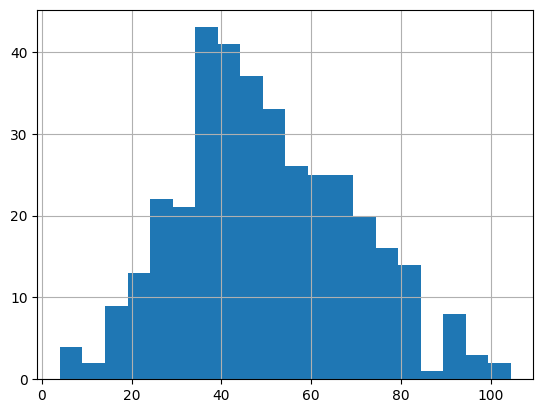

In [52]:
import pandas as pd
from datetime import date

# --- Configuration ---
SEASON_YEAR = 2026
DATA_PATH = "../data"
CSV_URL = f"http://barttorvik.com/{SEASON_YEAR}_team_results.csv"
OUTPUT_FILE = f"{DATA_PATH}/torvik_snapshot_{SEASON_YEAR}.csv"

# --- Fetch (let pandas use Bart's headers) ---
print(f"Fetching data from: {CSV_URL}")
df = pd.read_csv(CSV_URL)

# Save
df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Saved {len(df)} teams to: {OUTPUT_FILE}")
print(f"   Last updated: {date.today()}")

# --- Power Score (50% adjoe-adjde, 50% WAB) ---
# Note: "barthag" is at col 8, need to find adjEM or calculate it
# AdjEM = AdjOE - AdjDE
df['adjEM'] = df['adjoe'] - df['adjde']

df['adjEM_z'] = (df['adjEM'] - df['adjEM'].mean()) / df['adjEM'].std()
df['WAB_z'] = (df['WAB'] - df['WAB'].mean()) / df['WAB'].std()

df['Power_Score'] = (df['adjEM_z'] + df['WAB_z'] + 5) * 10
df['Power_Rank'] = df['Power_Score'].rank(ascending=False).astype(int)

# --- Display Top 50 ---
df_sorted = df.sort_values('Power_Score', ascending=False)
print("\nTop 50 Teams by Power Score (50% AdjEM + 50% WAB):")
print(df_sorted[['Power_Rank', 'team', 'conf', 'adjEM', 'rank', 'WAB', 'WAB Rk', 'Power_Score']].head(50).to_string(index=False))

# --- Make Power Score ---
print("\n--- Power Score Distribution ---")
print(df['Power_Score'].describe())

print(f"\nSkewness: {df['Power_Score'].skew():.3f}")
print(f"Kurtosis: {df['Power_Score'].kurtosis():.3f}")

# Quick histogram in terminal
print("\nHistogram:")
print(df['Power_Score'].hist(bins=20))

# Save Power Score CSV
POWER_SCORE_FILE = f"{DATA_PATH}/torvik_power_scores_{SEASON_YEAR}.csv"
df[['team', 'conf', 'adjEM', 'WAB', 'Power_Score', 'Power_Rank']].to_csv(POWER_SCORE_FILE, index=False)
print(f"\n✅ Saved Power Scores to: {POWER_SCORE_FILE}")

In [18]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# Setup Chrome
options = Options()
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Load the page
driver.get("https://barttorvik.com/teamstats.php?year=2026&sort=2")
time.sleep(5)

# Grab the table
tables = pd.read_html(driver.page_source)
df = max(tables, key=len)

driver.quit()

# Flatten multi-level column headers
df.columns = ['_'.join(str(i) for i in col).strip() for col in df.columns.values]

# Rename the first few columns
df.rename(columns={
    'Unnamed: 0_level_0_Rk': 'Rk',
    'Unnamed: 1_level_0_Team': 'Team', 
    'Unnamed: 2_level_0_Conf': 'Conf'
}, inplace=True)

# Extract just the stat value (first number) from numeric columns only
for col in df.columns:
    if col not in ['Rk', 'Team', 'Conf']:
        df[col] = df[col].astype(str).str.split().str[0]
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.head(10))
print(df.columns.tolist())

df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)
print(f"\n✅ Saved {len(df)} teams")

   Rk          Team  Conf  Adj. Eff._Off.  Adj. Eff._Def.  Eff. FG%_Off.  \
0   1  Colorado St.   MWC           120.8           108.1           64.5   
1   2       Liberty  CUSA           114.8           104.3           62.8   
2   3      Iowa St.   B12           121.8            93.7           62.8   
3   4         Akron   MAC           120.3           106.7           62.2   
4   5      Missouri   SEC           119.6           101.5           61.4   
5   6       Belmont   MVC           110.5           102.9           61.3   
6   7    Vanderbilt   SEC           126.7            98.7           61.2   
7   8      Michigan   B10           124.3            90.1           61.0   
8   9      Ohio St.   B10           119.7            99.8           61.0   
9  10       Cornell   Ivy           112.5           113.2           60.7   

   Eff. FG%_Def.  Turnover%_Off.  Turnover%_Def.  Off. Reb%_Off.  \
0           52.8            17.0            12.5            33.1   
1           50.3           

In [26]:
# Load both files
df_summary = pd.read_csv(f"{DATA_PATH}/torvik_snapshot_2026.csv")
df_stats = pd.read_csv(f"{DATA_PATH}/torvik_teamstats_2026.csv")

# Check column names
print("Summary columns:", df_summary.columns.tolist()[:10])
print("Stats columns:", df_stats.columns.tolist()[:10])

# Join on team name
df = df_summary.merge(df_stats, left_on='team', right_on='Team', how='left')

# Drop duplicate team column
df.drop(columns=['Team'], inplace=True)

# Save the real master
df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)

print(f"\n✅ Master table: {len(df)} teams, {len(df.columns)} columns")
print(df.columns.tolist())

Summary columns: ['rank', 'team', 'conf', 'record', 'adjoe', 'oe Rank', 'adjde', 'de Rank', 'barthag', 'rank.1']
Stats columns: ['Rk', 'Team', 'Conf', 'Adj. Eff._Off.', 'Adj. Eff._Def.', 'Eff. FG%_Off.', 'Eff. FG%_Def.', 'Turnover%_Off.', 'Turnover%_Def.', 'Off. Reb%_Off.']

✅ Master table: 365 teams, 63 columns
['rank', 'team', 'conf', 'record', 'adjoe', 'oe Rank', 'adjde', 'de Rank', 'barthag', 'rank.1', 'proj. W', 'Proj. L', 'Pro Con W', 'Pro Con L', 'Con Rec.', 'sos', 'ncsos', 'consos', 'Proj. SOS', 'Proj. Noncon SOS', 'Proj. Con SOS', 'elite SOS', 'elite noncon SOS', 'Opp OE', 'Opp DE', 'Opp Proj. OE', 'Opp Proj DE', 'Con Adj OE', 'Con Adj DE', 'Qual O', 'Qual D', 'Qual Barthag', 'Qual Games', 'FUN', 'ConPF', 'ConPA', 'ConPoss', 'ConOE', 'ConDE', 'ConSOSRemain', 'Conf Win%', 'WAB', 'WAB Rk', 'Fun Rk', 'adjt', 'Rk', 'Conf', 'Adj. Eff._Off.', 'Adj. Eff._Def.', 'Eff. FG%_Off.', 'Eff. FG%_Def.', 'Turnover%_Off.', 'Turnover%_Def.', 'Off. Reb%_Off.', 'Off. Reb%_Def.', 'FT Rate_Off.', 'F

adjoe             0
adjde             0
adjt              0
Eff. FG%_Off.     0
Eff. FG%_Def.     0
Turnover%_Off.    0
Turnover%_Def.    0
Off. Reb%_Off.    0
Off. Reb%_Def.    0
FT Rate_Off.      0
FT Rate_Def.      0
dtype: int64
Ready to cluster: 365 teams, 11 features


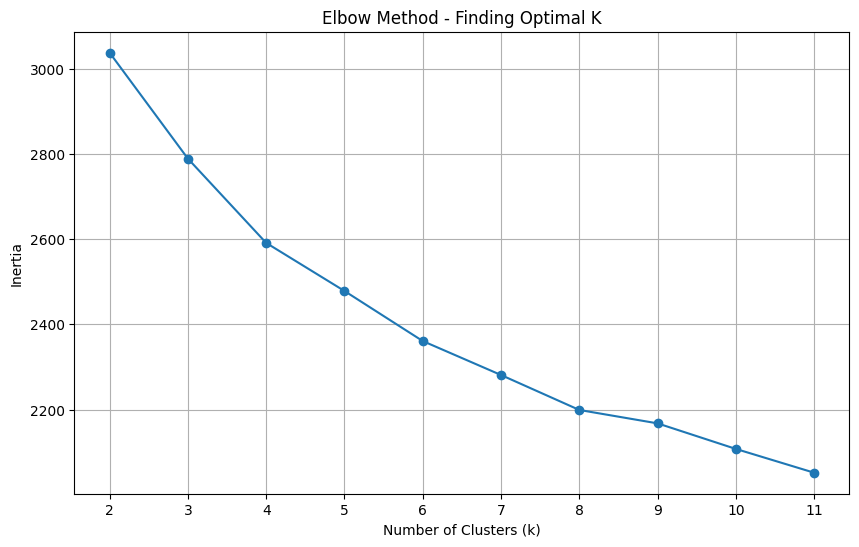

In [27]:
df = pd.read_csv(f"{DATA_PATH}/torvik_master_2026.csv")

features = [
    'adjoe', 'adjde', 'adjt',  # Efficiency + tempo
    'Eff. FG%_Off.', 'Eff. FG%_Def.',  # Shooting efficiency
    'Turnover%_Off.', 'Turnover%_Def.',  # Ball control
    'Off. Reb%_Off.', 'Off. Reb%_Def.',  # Rebounding
    'FT Rate_Off.', 'FT Rate_Def.'  # Free throw rate
]

# Check for missing values
print(df[features].isnull().sum())

# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

print(f"Ready to cluster: {df_scaled.shape[0]} teams, {df_scaled.shape[1]} features")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Finding Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [36]:
# Run clustering with k=6
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# See cluster profiles (mean of each feature by cluster)
print("Cluster Profiles:\n")
print(df.groupby('Cluster')[features].mean().round(1))

# Count teams per cluster
print("\nTeams per cluster:")
print(df['Cluster'].value_counts().sort_index())

archetype_names = {
    0: 'Methodical Mid-Majors',
    1: 'Physical Underdogs', 
    2: 'Elite Contenders',
    3: 'Quality Mid-Tier',
    4: 'Rebuilders',
    5: 'Efficient Underdogs'
}

df['Archetype'] = df['Cluster'].map(archetype_names)

# Save the updated master file
df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)

# Quick check
print(df[['team', 'Cluster', 'Archetype', 'barthag']].sort_values('barthag', ascending=False).head(20))

Cluster Profiles:

         adjoe  adjde  adjt  Eff. FG%_Off.  Eff. FG%_Def.  Turnover%_Off.  \
Cluster                                                                     
0        105.2  104.9  66.8           49.3           48.3            18.4   
1        103.5  110.5  70.5           47.9           54.4            18.4   
2        118.3  100.1  69.2           55.8           47.1            15.5   
3        110.5  103.0  70.0           53.5           49.5            16.9   
4         99.2  113.4  68.0           46.6           55.1            20.3   
5        106.6  110.3  68.1           51.8           52.0            16.8   

         Turnover%_Def.  Off. Reb%_Off.  Off. Reb%_Def.  FT Rate_Off.  \
Cluster                                                                 
0                  17.8            33.8            30.0          35.1   
1                  18.4            30.7            32.4          37.7   
2                  17.6            36.2            28.5          38.0   

In [45]:
# Sub-cluster the elite teams (Cluster 2)
elite_mask = df['Cluster'] == 2
elite_scaled = scaler.transform(df.loc[elite_mask, features])

kmeans_elite = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[elite_mask, 'SubCluster'] = kmeans_elite.fit_predict(elite_scaled)

# Sub-cluster the quality mid-tier (Cluster 3)
mid_mask = df['Cluster'] == 3
mid_scaled = scaler.transform(df.loc[mid_mask, features])

kmeans_mid = KMeans(n_clusters=3, random_state=42, n_init=10)
df.loc[mid_mask, 'SubCluster'] = kmeans_mid.fit_predict(mid_scaled) + 10  # offset to differentiate

# Check elite sub-clusters
print("=== ELITE CONTENDERS SUB-CLUSTERS ===\n")
for sc in [0, 1, 2]:
    print(f"--- Elite Sub-Cluster {sc} ---")
    subset = df[(df['Cluster'] == 2) & (df['SubCluster'] == sc)].sort_values('barthag', ascending=False)
    print(subset[['team', 'conf', 'adjoe', 'adjde', 'adjt', 'barthag']].head(10).to_string(index=False))
    print()

# Check mid-tier sub-clusters  
print("\n=== QUALITY MID-TIER SUB-CLUSTERS ===\n")
for sc in [10, 11, 12]:
    print(f"--- Mid-Tier Sub-Cluster {sc} ---")
    subset = df[(df['Cluster'] == 3) & (df['SubCluster'] == sc)].sort_values('barthag', ascending=False)
    print(subset[['team', 'conf', 'adjoe', 'adjde', 'adjt', 'barthag']].head(10).to_string(index=False))
    print()

# Elite sub-cluster profiles
print("=== ELITE CONTENDERS SUB-CLUSTERS ===\n")
elite_df = df[df['Cluster'] == 2]
print(elite_df.groupby('SubCluster')[features].mean().round(1))
print("\nTeams per sub-cluster:")
print(elite_df['SubCluster'].value_counts().sort_index())

# Mid-tier sub-cluster profiles
print("\n\n=== QUALITY MID-TIER SUB-CLUSTERS ===\n")
mid_df = df[df['Cluster'] == 3]
print(mid_df.groupby('SubCluster')[features].mean().round(1))
print("\nTeams per sub-cluster:")
print(mid_df['SubCluster'].value_counts().sort_index())

# Create final archetype labels
def assign_archetype(row):
    if row['Cluster'] == 2:
        if row['SubCluster'] == 0:
            return 'Ball Pressure Contender (Elite)'
        elif row['SubCluster'] == 1:
            return 'Fast to the Rack Contender (Elite)'
        elif row['SubCluster'] == 2:
            return 'Almost Contender Grinders (Elite)'
    elif row['Cluster'] == 3:
        if row['SubCluster'] == 10:
            return 'Shutdown D (Mid-Tier)'
        elif row['SubCluster'] == 11:
            return 'Attack the Rim (Mid-Tier)'
        elif row['SubCluster'] == 12:
            return 'Board Dominant (Mid-Tier)'
    else:
        return row['Archetype']  # Keep original for clusters 0,1,3,4

df['Archetype'] = df.apply(assign_archetype, axis=1)

# Check the distribution
print(df['Archetype'].value_counts())

# Save
df.to_csv(f"{DATA_PATH}/torvik_master_2026.csv", index=False)
print("\n✅ Saved with updated archetypes")



=== ELITE CONTENDERS SUB-CLUSTERS ===

--- Elite Sub-Cluster 0 ---
        team conf      adjoe     adjde      adjt  barthag
     Houston  B12 118.639473 90.688297 63.823853 0.956462
     Gonzaga  WCC 121.758441 93.414483 71.461142 0.954671
    Iowa St.  B12 121.769860 93.689771 70.462446 0.953232
 Connecticut   BE 121.798274 94.531941 66.073794 0.948555
  Vanderbilt  SEC 126.685095 98.730035 70.744869 0.946197
Michigan St.  B10 118.082537 92.207452 65.863773 0.945031
   Tennessee  SEC 119.077059 94.908731 68.383203 0.931428
     Indiana  B10 117.915496 97.045249 68.942396 0.903793
        UCLA  B10 118.329646 97.672710 66.315076 0.900814
    Miami FL  ACC 115.883053 97.767039 71.575978 0.875983

--- Elite Sub-Cluster 1 ---
      team conf      adjoe     adjde      adjt  barthag
  Michigan  B10 124.277590 90.122034 72.594354 0.975768
      Duke  ACC 121.757410 92.282124 68.025217 0.960364
Louisville  ACC 124.105307 97.668202 71.651786 0.940188
   Alabama  SEC 126.267506 99.897766 73.93

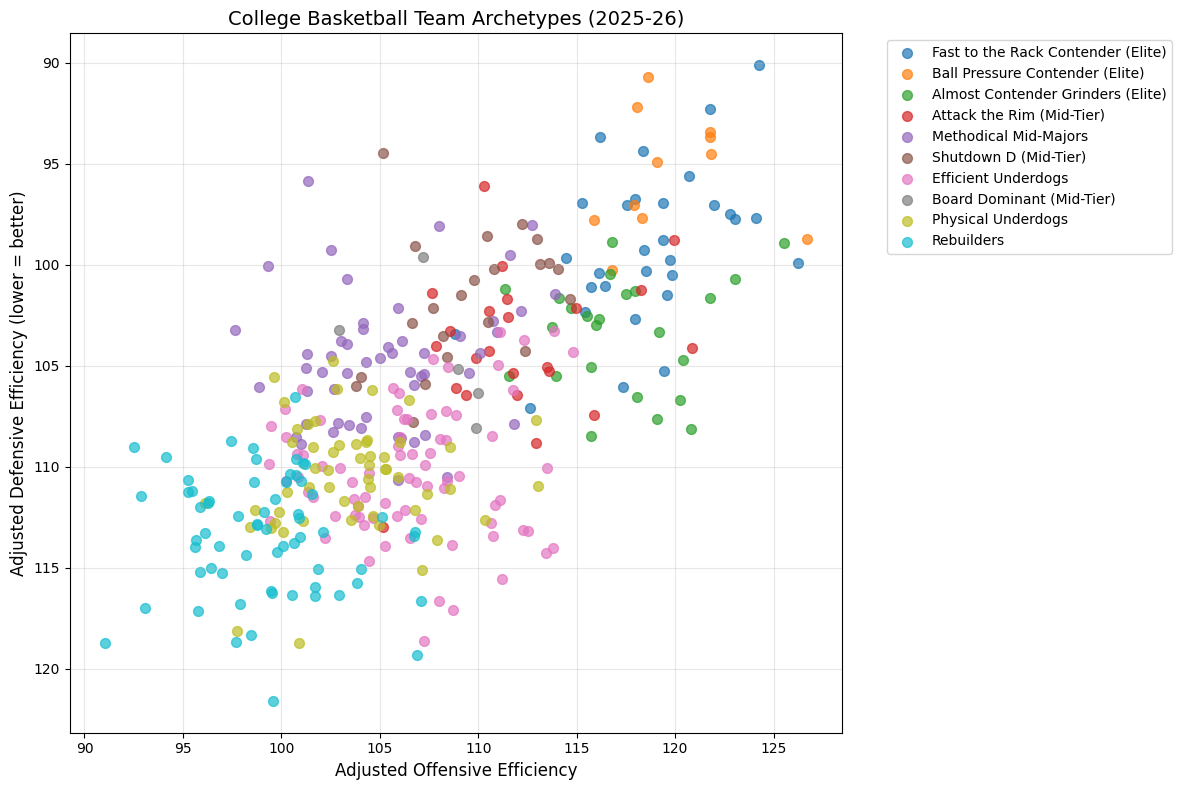

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Get unique archetypes and assign colors
archetypes = df['Archetype'].unique()
colors = plt.cm.tab10(range(len(archetypes)))

for arch, color in zip(archetypes, colors):
    subset = df[df['Archetype'] == arch]
    ax.scatter(subset['adjoe'], subset['adjde'], label=arch, alpha=0.7, s=50, c=[color])

# Invert y-axis (lower adjde = better defense = higher on chart)
ax.invert_yaxis()

ax.set_xlabel('Adjusted Offensive Efficiency', fontsize=12)
ax.set_ylabel('Adjusted Defensive Efficiency (lower = better)', fontsize=12)
ax.set_title('College Basketball Team Archetypes (2025-26)', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
import pandas as pd
import numpy as np

# Create archetype summary
archetype_summary = df.groupby('Archetype')[features].mean()

# Add team count
archetype_summary['Teams'] = df.groupby('Archetype').size()

# Add AdjEM (offensive efficiency - defensive efficiency)
archetype_summary['AdjEM'] = archetype_summary['adjoe'] - archetype_summary['adjde']

# Reorder columns to put Teams and AdjEM first
cols = ['Teams', 'AdjEM'] + features
archetype_summary = archetype_summary[cols]

# Sort by AdjEM descending
archetype_summary = archetype_summary.sort_values('AdjEM', ascending=False)

# Define which metrics are "better" when higher vs lower
higher_is_better = ['adjoe', 'AdjEM', 'Eff. FG%_Off.', 'Turnover%_Def.', 'Off. Reb%_Off.', 'FT Rate_Off.']
lower_is_better = ['adjde', 'Eff. FG%_Def.', 'Turnover%_Off.', 'Off. Reb%_Def.', 'FT Rate_Def.']

# Style function with darker colors and white text
def style_table(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    
    for col in df.columns:
        if col == 'Teams' or col == 'adjt':
            continue
        mean = df[col].mean()
        std = df[col].std()
        
        for idx in df.index:
            val = df.loc[idx, col]
            z = (val - mean) / std if std > 0 else 0
            
            if col in higher_is_better:
                if z > 0.5:
                    styles.loc[idx, col] = 'background-color: #228B22; color: white'  # forest green
                elif z < -0.5:
                    styles.loc[idx, col] = 'background-color: #DC143C; color: white'  # crimson
            elif col in lower_is_better:
                if z < -0.5:
                    styles.loc[idx, col] = 'background-color: #228B22; color: white'  # forest green
                elif z > 0.5:
                    styles.loc[idx, col] = 'background-color: #DC143C; color: white'  # crimson
    
    return df.style.apply(lambda _: styles, axis=None).format(precision=1)

style_table(archetype_summary)

,Teams,AdjEM,adjoe,adjde,adjt,Eff. FG%_Off.,Eff. FG%_Def.,Turnover%_Off.,Turnover%_Def.,Off. Reb%_Off.,Off. Reb%_Def.,FT Rate_Off.,FT Rate_Def.
Archetype,,,,,,,,,,,,,
Ball Pressure Contender (Elite),11,24.2,119.7,95.5,68.5,55.7,45.1,15.3,20.6,37.1,28.0,32.6,36.5
Fast to the Rack Contender (Elite),30,19.6,118.7,99.1,71.0,55.9,46.0,16.0,16.9,35.7,27.8,40.1,29.5
Almost Contender Grinders (Elite),24,13.9,117.3,103.4,67.2,55.8,49.3,15.1,17.0,36.3,29.7,37.8,30.2
Attack the Rim (Mid-Tier),23,8.1,112.0,103.9,69.5,53.3,51.3,15.4,20.7,30.8,28.5,43.4,36.7
Shutdown D (Mid-Tier),22,7.7,109.5,101.8,70.0,53.6,48.2,17.9,21.8,31.5,31.6,37.4,36.5
Board Dominant (Mid-Tier),5,3.3,107.8,104.5,71.8,53.7,47.2,19.1,18.6,35.1,26.6,44.8,49.0
Methodical Mid-Majors,54,0.3,105.2,104.9,66.8,49.3,48.3,18.4,17.8,33.8,30.0,35.1,36.5
Efficient Underdogs,77,-3.7,106.6,110.3,68.1,51.8,52.0,16.8,15.6,27.9,30.9,33.9,33.1
Physical Underdogs,55,-7.0,103.5,110.5,70.5,47.9,54.4,18.4,18.4,30.7,32.4,37.7,43.6


In [50]:
# Find team's archetype and show their stats
team_name = "Rutgers"

team_row = df[df['team'] == team_name][['team', 'Archetype'] + features]
print(f"{team_name} is classified as: {team_row['Archetype'].values[0]}\n")

# Show their stats vs archetype average
team_stats = df[df['team'] == team_name][features].iloc[0]
archetype = df[df['team'] == team_name]['Archetype'].values[0]
archetype_avg = df[df['Archetype'] == archetype][features].mean()

comparison = pd.DataFrame({
    team_name: team_stats,
    'Archetype Avg': archetype_avg
}).T

comparison

Rutgers is classified as: Methodical Mid-Majors



,adjoe,adjde,adjt,Eff. FG%_Off.,Eff. FG%_Def.,Turnover%_Off.,Turnover%_Def.,Off. Reb%_Off.,Off. Reb%_Def.,FT Rate_Off.,FT Rate_Def.
Rutgers,106.736810,105.947537,65.994533,47.500000,50.900000,17.200000,16.900000,34.000000,33.000000,39.700000,25.2
Archetype Avg,105.202116,104.889486,66.792017,49.322222,48.294444,18.388889,17.837037,33.809259,30.040741,35.124074,36.5
